In [1]:
import torch
import numpy as np

import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:

class Assign_Model(nn.Module):
    
    def __init__(self,in_size,hidden1_size,hidden2_size,out_size):
        super().__init__()
        
        self.input_l = nn.Linear(in_size,hidden1_size)
        
        self.hidden1_l = nn.Linear(hidden1_size,hidden2_size)
        
        self.hidden2_l = nn.Linear(hidden2_size,out_size)
        
    def forward(self,features):
        
        out_i = self.input_l( features )
        
        act_h1 = torch.tanh( out_i )
        
        out_h1 = self.hidden1_l( act_h1 )
        
        act_h2 = torch.tanh( out_h1 )
        
        Final_out = self.hidden2_l( act_h2 )
        
        return Final_out
        


# Task 1: Function Approximation

### Extracting data


In [3]:
inputs = np.genfromtxt('Data/task1/func_app0.csv',delimiter = ',')[1:]
print(inputs)

np.random.shuffle(inputs)


train, rem = np.split( inputs, [int(0.7 * len(inputs))] , axis = 0)

val , test   = np.split( rem , [int(0.33333 * len(rem))] , axis = 0)

print(len(train))
print(len(val))
print(len(test))


inputs = torch.from_numpy(inputs).float()
train = torch.from_numpy(train).float()
test  = torch.from_numpy(test).float()
val   = torch.from_numpy(val).float()



[[4.32109779 4.76960925 1.85127693]
 [1.96991501 1.87050888 1.76181507]
 [3.4552784  3.40238605 0.16169853]
 ...
 [1.4092186  4.42929224 1.89609354]
 [5.80195409 4.1582189  0.93732329]
 [4.9527989  3.6769021  1.2035174 ]]
350
49
101


### Function Approximation model


In [5]:
Approx_model = Assign_Model(2,500,500,1)

Delta_w = []
# print(Approx_model.parameters())
for param in Approx_model.parameters():
#     print(param.size())
    Delta_w.append(torch.zeros(param.size()))
    
    
loss_fn = F.mse_loss


lr = 1e-4

al = 0.9


### Training Phase


In [6]:
Average_loss = []
Z = []
val_min_loss = 100
count_min_change = 0

def Plot_Approx_function():
    global Z
    Total_loss = 0
    z = []
    with torch.no_grad():
        for inp in inputs:
            preds = Approx_model(inp[:2])
            z.append(preds[0].item())
    Z.append(z)
 

In [7]:
num_epochs = 9000
for epoch in range(num_epochs):
    
    
    Total_loss_Train = 0
    for inp in train:
        preds = Approx_model(inp[:2])
        
        loss = loss_fn(preds[0],inp[2])
        
        Total_loss_Train += loss.item()
        loss.backward()
        
        with torch.no_grad():
            
            i = 0
            for param in Approx_model.parameters():
                
                Delta_w[i] =  - (lr*param.grad) + (al*Delta_w[i])
                
                param += (Delta_w[i])
                
                param.grad.zero_()
                
                i += 1
    Average_loss.append(Total_loss_Train/len(train)) 
    
    if (epoch+1) % 100 == 0 and epoch != 99 and Average_loss[-100] - Average_loss[-1] < 0.0001:
        Plot_Approx_function()
        break
        
    
    
    Total_loss = 0
    with torch.no_grad():
        for inp in val:
            preds = Approx_model(inp[:2])

            loss = loss_fn(preds[0],inp[2])
            Total_loss += loss.item()
        
    if val_min_loss <= Total_loss:
        count_min_change += 1
    else:
        val_min_loss = Total_loss
        count_min_change = 0
      
    if epoch >=1000 and count_min_change == 100 :
        Plot_Approx_function()
        break
        
    

    if epoch == 1 or epoch == 2 or epoch == 10 or epoch == 50:
        Plot_Approx_function()
        
    

    if (epoch+1) % 500 == 0:
        print('Epoch [{}/{}], Average_Loss_Train: {:.4f}, Average_Loss_Val: {:.4f}'.format(epoch+1,num_epochs, Total_loss_Train/len(train),Total_loss/len(val)))

Epoch [500/9000], Average_Loss_Train: 0.0222, Average_Loss_Val: 0.0132
Epoch [1000/9000], Average_Loss_Train: 0.0035, Average_Loss_Val: 0.0029
Epoch [1500/9000], Average_Loss_Train: 0.0016, Average_Loss_Val: 0.0023


In [8]:
print(val_min_loss/len(val))
print(Total_loss/len(val))
torch.save(Approx_model.state_dict(), 'Task1_params_ver2.pth')

0.0017097961012115441
0.0017097961012115441


### Loss vs Epoch


range(0, 2000)
1999


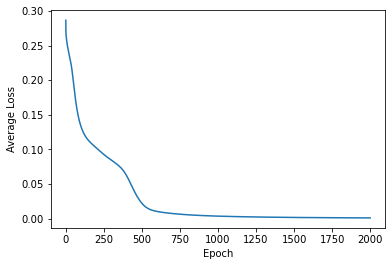

In [9]:
start = 0
end = len(Average_loss)
X1 = range(start,end)
Y1 = Average_loss[start:end]

print(X1)
plt.plot(X1, Y1)
plt.xlabel('Epoch')

plt.ylabel('Average Loss')
 
print(epoch)

### Scatter Plot


Text(0.5, 1.0, 'Model Output vs Desired Output')

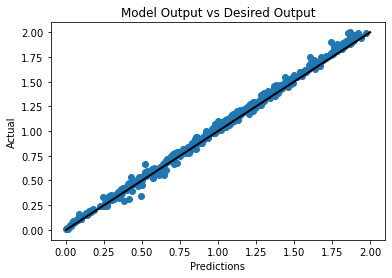

In [10]:

predictions = []
actual = []
with torch.no_grad():
    for inp in inputs:

        preds = Approx_model(inp[:2])
        predictions.append(preds[0].item())
        actual.append(inp[2].item())
    
plt.scatter(predictions, actual)
plt.plot([0, 2], [0, 2], color = 'black', linewidth = 2)

plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Model Output vs Desired Output')

### Function plot

In [11]:
epoch_map = [1,2,10,50,'Final']


def Plot(i,ii,jj):
    ax = fig.add_subplot(gs[ii, jj],projection = '3d')
    ax.plot_trisurf( inputs[:,1].numpy(), inputs[:,0].numpy(),np.array(Z[i]), linewidth=0, antialiased=False)
    ax.set_title('approximated function after epoch {}'.format(epoch_map[i]),fontsize=15)
    ax.set_xlabel('x2',fontsize=15)
    ax.set_ylabel('x1',fontsize=15)
    ax.set_zlabel('y',fontsize=15)

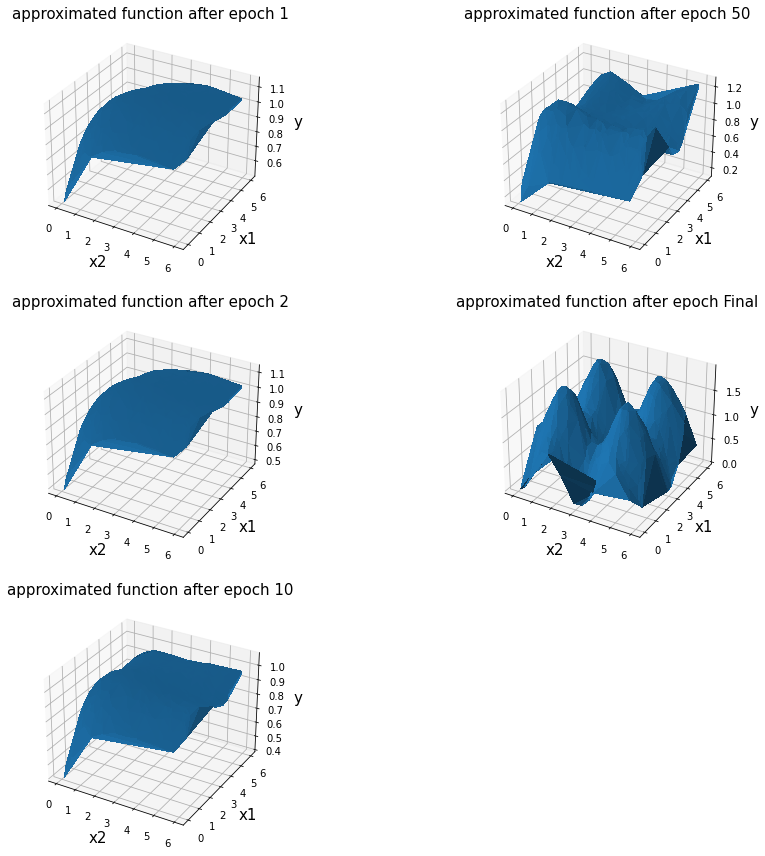

In [12]:
epoch_map = [1,2,10,50,'Final']

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=2)

Plot(0,0,0)
Plot(1,1,0)
Plot(2,2,0)
Plot(3,0,1)
Plot(4,1,1)

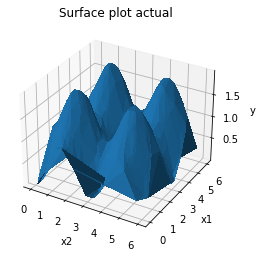

In [13]:
# print(train[:,2].numpy())
ax = plt.axes(projection ='3d')
ax.plot_trisurf( inputs[:,1].numpy(), inputs[:,0].numpy() , inputs[:,2].numpy(), linewidth=0, antialiased=False)
ax.set_title('Surface plot actual')
ax.set_xlabel('x2')
ax.set_ylabel('x1')
ax.set_zlabel('y')
plt.show()  